In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import utils

In [80]:
raw_data = pd.read_csv('data/train/Data_S06_Sess04.csv')
feedback_times = raw_data[raw_data['FeedBackEvent'] == 1]['Time']
fs = 200 # sampling frequency
default_channel = 'Fp1'

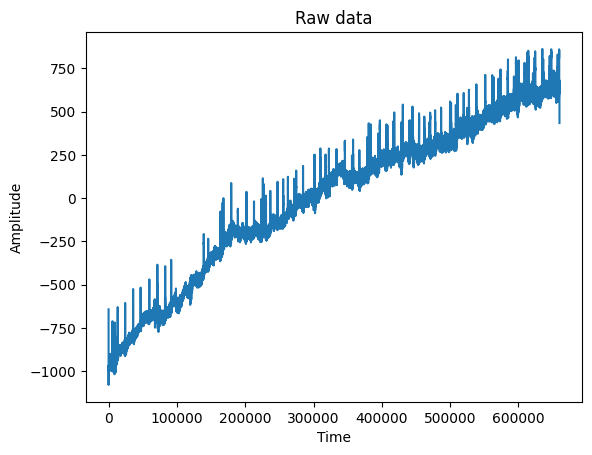

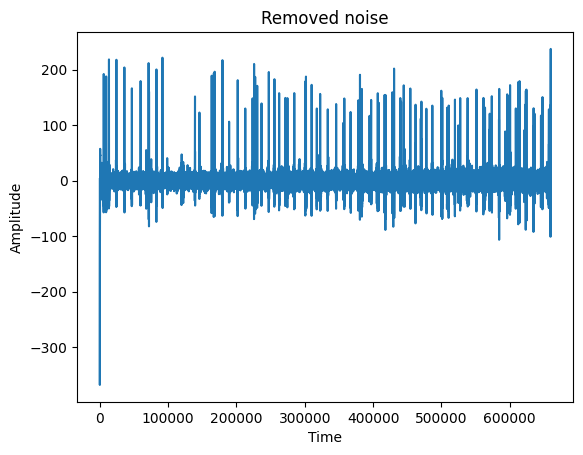

0           2.874264
1        -188.157825
2        -320.121145
3        -367.949003
4        -349.625192
             ...    
131996    230.738165
131997    237.428025
131998    207.225186
131999    133.669984
132000     30.682843
Name: Fp1, Length: 132001, dtype: float64


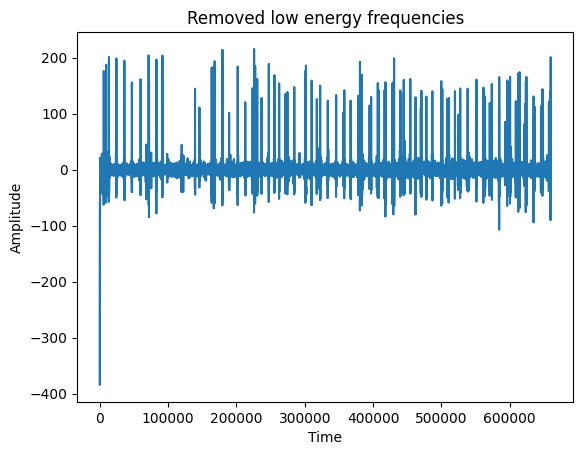

In [81]:
utils.plot_channel(raw_data, 0, default_channel, title='Raw data')

temp = utils.bandpass_filter_all(raw_data, highcut=30)
utils.plot_channel(temp, 0, default_channel, title='Removed noise')
print(temp[default_channel])
filtered_data = utils.bandpass_filter_all(temp, lowcut=0.2, highcut=10)
utils.plot_channel(filtered_data, 0, default_channel, title='Removed low energy frequencies')

In [ ]:
# Idea: apply DBSCAN to detect segments of the signal where there are P300 potentials
window_size = int(0.5 * fs)
step_size = int(0.2 * fs)

process_channels = [col for col in filtered_data.columns if (col != 'Time' and col != 'FeedBackEvent' and col != 'EOG')]
#print(process_channels, len(process_channels))

features = []
timestamps = []

# Sliding window feature extraction
for start in range(0, len(filtered_data) - window_size, step_size):
    segment = filtered_data.iloc[start:start + window_size][process_channels]
    time_stamp = filtered_data.iloc[start]["Time"]  # Save the start time of the segment
    
    avg_signal = segment.mean(axis=1)  # Average across channels
    
    # Feature extraction
    peak_amp = np.max(avg_signal)  # Max amplitude
    peak_lat = np.argmax(avg_signal)  # Latency of peak
    peak_to_peak = np.max(avg_signal) - np.min(avg_signal)  # Peak-to-peak amplitude
    #slope = (avg_signal[peak_lat] - avg_signal[peak_lat - 2]) / 2  # Approximate slope
    
    # Power spectral density (Welch method)
    f, Pxx = welch(avg_signal, fs=fs, nperseg=window_size//2)
    delta_power = np.sum(Pxx[(f >= 0.5) & (f < 4)])  # Delta band power
    theta_power = np.sum(Pxx[(f >= 4) & (f < 8)])  # Theta band power
    
    features.append([peak_amp, peak_lat, delta_power, theta_power, peak_to_peak])
    timestamps.append(time_stamp)

# Convert to DataFrame
features_df = pd.DataFrame(features, columns=["Peak_Amp", "Peak_Lat", "Delta_Power", "Theta_Power", "Peak_to_Peak"])
features_df["Timestamp"] = timestamps  # Add time info

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df.drop(columns=["Timestamp"]))

In [83]:
print(features_scaled.shape)

(3298, 5)


In [84]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.30, min_samples=10)  # Adjust eps based on feature scale
labels = dbscan.fit_predict(features_scaled)

# Add cluster labels to DataFrame
features_df["Cluster"] = labels

# Identify the cluster that contains P300
valid_clusters = [c for c in set(labels) if c != -1]  # Ignore noise (-1)
p300_cluster = max(valid_clusters, key=lambda c: features_df[features_df["Cluster"] == c]["Peak_Amp"].mean())

# Extract P300-like segments
p300_segments = features_df[features_df["Cluster"] == p300_cluster]

print("Detected P300 segments:")
print(p300_segments[["Timestamp", "Peak_Amp", "Peak_Lat"]])

print(f'Found {len(p300_segments)} P300 segments')

Detected P300 segments:
      Timestamp   Peak_Amp  Peak_Lat
6           1.2  19.648323        90
7           1.4  19.648323        50
8           1.6  19.648323        10
9           1.8  15.732681        93
10          2.0  16.535395        96
...         ...        ...       ...
3290      658.0  13.614560        21
3291      658.2   9.814399         0
3292      658.4   8.062988        60
3293      658.6  15.899226        86
3294      658.8  15.899226        46

[2895 rows x 3 columns]
Found 2895 P300 segments


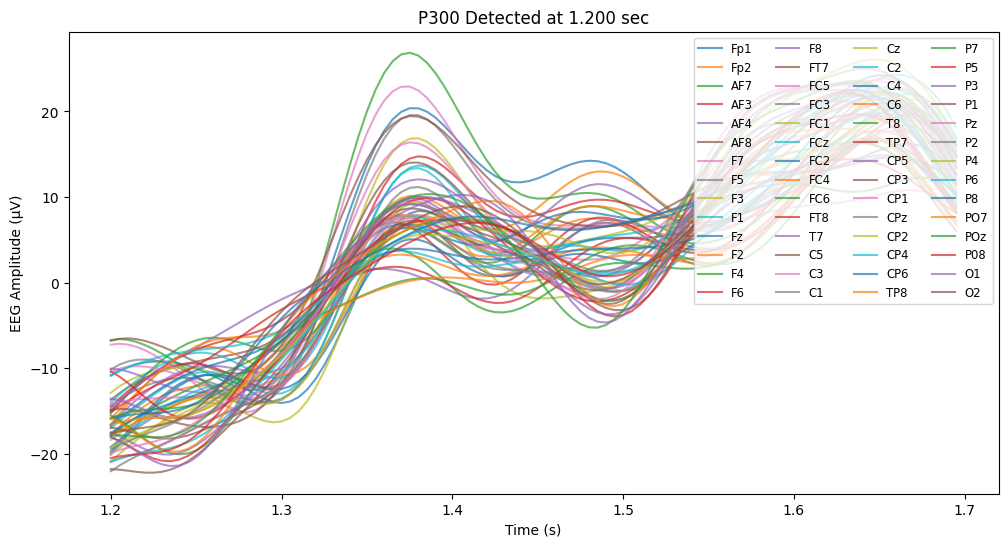

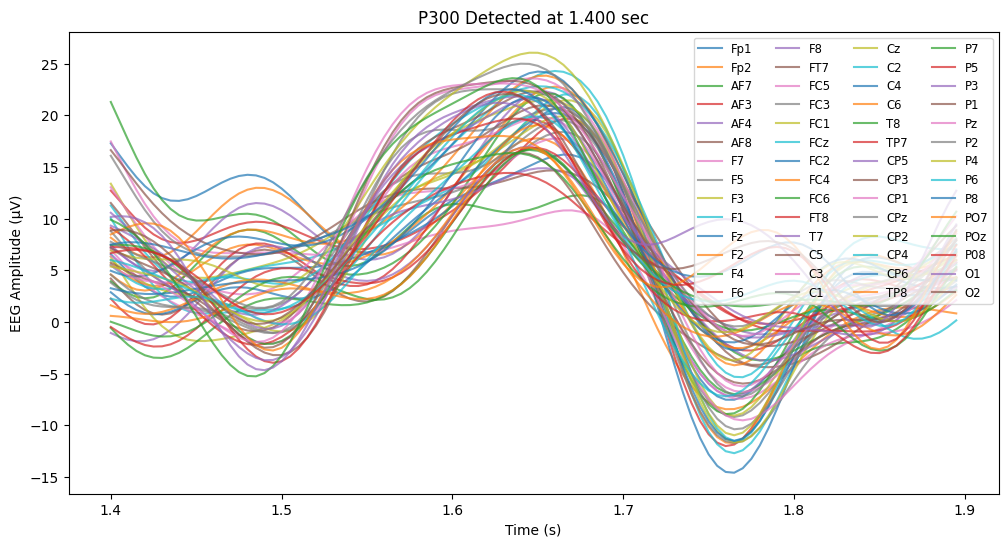

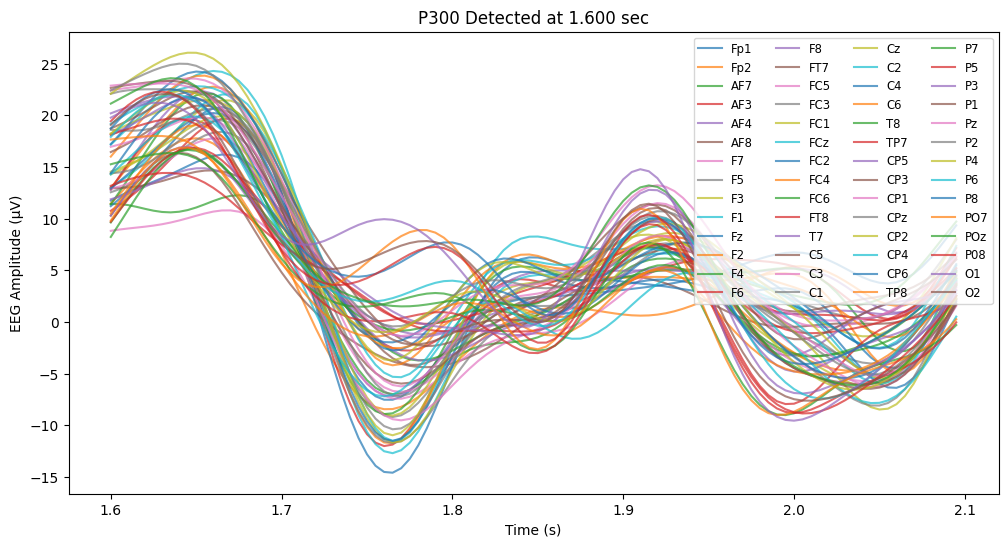

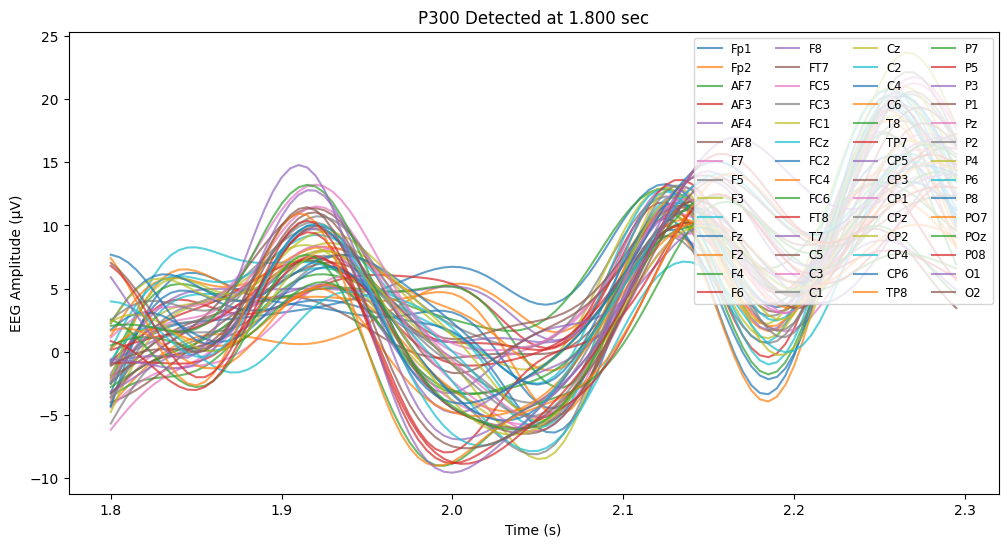

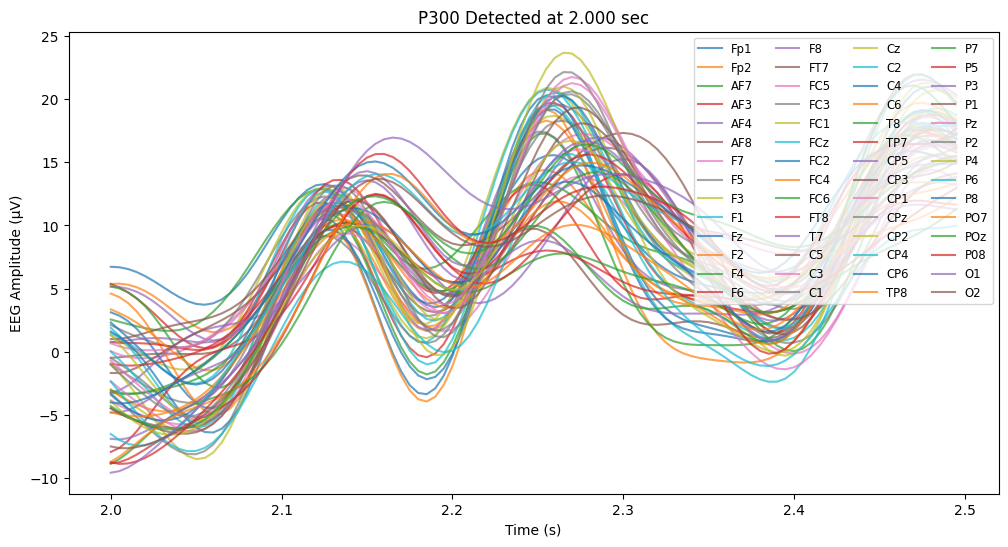

In [85]:
# Number of segments to plot (modify as needed)
num_segments_to_plot = 5
selected_segments = p300_segments.head(num_segments_to_plot)  # Select first N detected P300 segments

# Plot each selected P300 segment
for i, row in selected_segments.iterrows():
    t = row["Timestamp"]
    
    # Extract EEG window starting at detected P300 timestamp
    start_idx = filtered_data[filtered_data["Time"] == t].index[0]
    segment = filtered_data.iloc[start_idx:start_idx + window_size]  # Extract window
    
    plt.figure(figsize=(12, 6))
    
    # Plot each EEG channel
    for channel in process_channels:
        plt.plot(segment["Time"], segment[channel], label=channel, alpha=0.7)
    
    plt.title(f"P300 Detected at {t:.3f} sec")
    plt.xlabel("Time (s)")
    plt.ylabel("EEG Amplitude (µV)")
    plt.legend(loc="upper right", fontsize="small", ncol=4)
    plt.show()